In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf

import pandas as pd
import numpy as np
import urllib
import json
import datetime

from utils import plot_series

In [ ]:
!pip install --user kfp --upgrade

In [3]:
train_dataset = pd.read_csv("data/dataset.csv")
eval_dataset = pd.read_csv("data/dataset_eval.csv")

time_train = np.array(train_dataset.times)
x_train = np.array(train_dataset.values)[:,1].astype('float32')

time_eval = np.array(eval_dataset.times)
x_eval = np.array(eval_dataset.values)[:,1].astype('float32')

In [45]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """
    Description:  
    Input: 
      - series:
      - window_size:
      - batch_size: the batches to use when training
      -shuffle_buffer: size buffer, how data will be shuffled

    Output:

  """
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1])) # x and y (last one)
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

window_size = 7
batch_size = 16
shuffle_buffer_size = 100

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

0.01864544


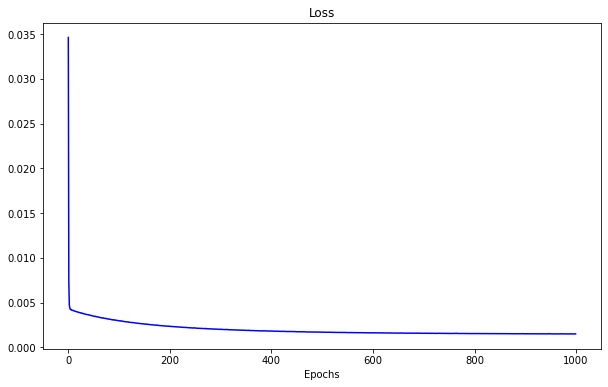

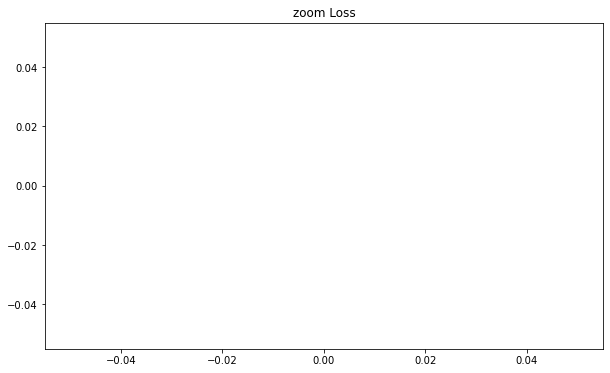

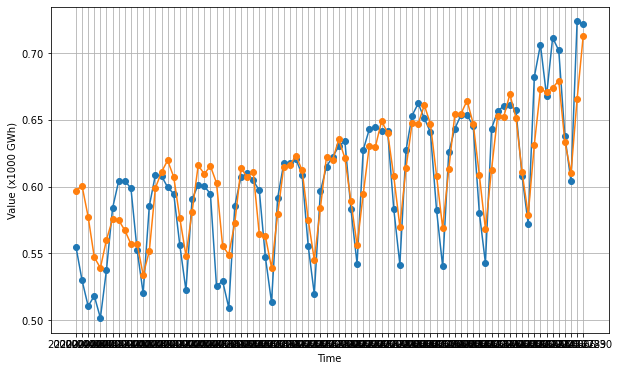

In [46]:
# Dense NN

EPOCHS = 1000
LR = 1e-3

l0 = tf.keras.layers.Dense(2*window_size+1, input_shape=[window_size], activation='relu')
l2 = tf.keras.layers.Dense(1)
model = tf.keras.models.Sequential([l0, l2])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3)

optimizer = tf.keras.optimizers.SGD(lr=LR, momentum=0.9)

model.compile(loss="mse", optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=EPOCHS, verbose=0)

#------------------------------------------------
# Plot Loss
#------------------------------------------------
loss=history.history['loss']
epochs_=range(len(loss)) # Get number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs_, loss, 'b')
plt.title('Loss')
plt.xlabel("Epochs")

n_epochs = 2000
plt.figure(figsize=(10, 6))
plt.plot(epochs_[n_epochs:], loss[n_epochs:], 'b')
plt.title('zoom Loss')



#------------------------------------------------
# Forecasting and evaluation
#------------------------------------------------

eval_dataset = windowed_dataset(x_eval, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
result = np.array(model.predict(eval_dataset))[:, 0]


plt.figure(figsize=(10, 6))
plot_series(time_eval[window_size:], x_eval[window_size:], format='-o')
plot_series(time_eval[window_size:], results, format='-o')

print(tf.keras.metrics.mean_absolute_error(x_eval[window_size:], results).numpy())    

0.01864544


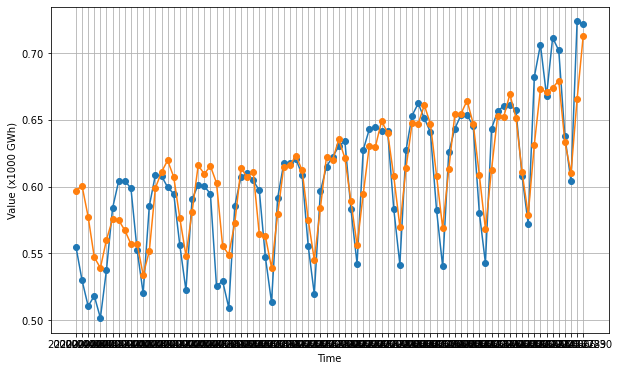

In [61]:
#------------------------------------------------
# Forecasting and evaluation
#------------------------------------------------

eval_dataset = windowed_dataset(x_eval, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
result = np.array(model.predict(eval_dataset))[:, 0]


plt.figure(figsize=(10, 6))
plot_series(time_eval[window_size:], x_eval[window_size:], format='-o')
plot_series(time_eval[window_size:], results, format='-o')

print(tf.keras.metrics.mean_absolute_error(x_eval[window_size:], results).numpy())  

# TF in a KFP running in AI Platform

1. Create the training script
2. Package training script into a Docker Image
3. Build and push training image to Google Cloud Container Registry

In [47]:
!mkdir tensorflow_trainer_image

In [62]:
%%writefile ./tensorflow_trainer_image/train.py

"""Tensorflow predictor script."""

import pickle
import subprocess
import sys
import fire
import pandas as pd
import tensorflow as tf
import datetime
import os

def load_dataset(pattern, window_size=30, batch_size=16, shuffle_buffer=100):
    """
    Description:  
    Input: 
      - series:
      - window_size:
      - batch_size: the batches to use when training
      -shuffle_buffer: size buffer, how data will be shuffled

    Output:
    """
    
    # read data
    data = pd.read_csv(pattern)
    time = np.array(data.times)
    series = np.array(data.values)[:,1].astype('float32')
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1])) # x and y (last one)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def train_evaluate(training_dataset_path, 
                   # validation_dataset_path,
                   window_size,
                   batch_size,
                   epochs, lr,
                   # num_train_examples, num_evals, 
                   output_dir):
    """
    Description: train script
    """
    
    EPOCHS = epochs
    LR = lr
    
    l0 = tf.keras.layers.Dense(2*window_size+1, input_shape=[window_size], activation='relu')
    l2 = tf.keras.layers.Dense(1)
    model = tf.keras.models.Sequential([l0, l2])
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3)
    optimizer = tf.keras.optimizers.SGD(lr=LR, momentum=0.9)
    model.compile(loss="mse", optimizer=optimizer, metrics=['mae'])
    
    # load data
    trainds = load_dataset(pattern=training_dataset_path, window_size=window_size, batch_size=batch_size)
    # evalds = load_dataset(pattern=validation_dataset_path, mode='eval')
    
    history = model.fit(trainds, epochs=EPOCHS, verbose=0)
    
    EXPORT_PATH = os.path.join(output_dir, datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
    tf.saved_model.save(obj=model, export_dir=EXPORT_PATH)  # with default serving function
    
    print("Exported trained model to {}".format(EXPORT_PATH))
    
if __name__ == '__main__':
    fire.Fire(train_evaluate)

Writing ./tensorflow_trainer_image/train.py


## Package TensorFlow Training Script into a Docker Image

In [63]:
%%writefile ./tensorflow_trainer_image/Dockerfile

FROM gcr.io/deeplearning-platform-release/base-cpu
RUN pip install -U fire tensorflow==2.1.1
WORKDIR /app
COPY train.py .

ENTRYPOINT ["python", "train.py"]

Writing ./tensorflow_trainer_image/Dockerfile


## Build the Tensorflow Trainer Image

In [2]:
REGION = 'us-central1'
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]
BUCKET = 'gs://' + PROJECT_ID

In [84]:
!gsutil cp -r data gs://qwiklabs-gcp-04-699809b7c735

Copying file://data/data.json [Content-Type=application/json]...
Copying file://data/dataset_eval.csv [Content-Type=text/csv]...                 
Copying file://data/dataset.csv [Content-Type=text/csv]...                      
Copying file://data/.ipynb_checkpoints/dataset_eval-checkpoint.csv [Content-Type=text/csv]...
/ [4 files][ 42.3 KiB/ 42.3 KiB]                                                
Operation completed over 4 objects/42.3 KiB.                                     


In [3]:
TF_IMAGE_NAME='tensorflow_trainer_image'
TF_IMAGE_TAG='latest'
TF_IMAGE_URI='gcr.io/{}/{}:{}'.format(PROJECT_ID, TF_IMAGE_NAME, TF_IMAGE_TAG)

In [67]:
!gcloud builds submit --tag $TF_IMAGE_URI $TF_IMAGE_NAME

Creating temporary tarball archive of 3 file(s) totalling 2.6 KiB before compression.
Uploading tarball of [tensorflow_trainer_image] to [gs://qwiklabs-gcp-04-699809b7c735_cloudbuild/source/1631438301.234398-5ec8e2b2a19f4b5cbe39f8d2726a4cd6.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/qwiklabs-gcp-04-699809b7c735/locations/global/builds/3a5db627-4ff8-457c-a243-54530dfa7d9d].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/3a5db627-4ff8-457c-a243-54530dfa7d9d?project=929326442256].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "3a5db627-4ff8-457c-a243-54530dfa7d9d"

FETCHSOURCE
Fetching storage object: gs://qwiklabs-gcp-04-699809b7c735_cloudbuild/source/1631438301.234398-5ec8e2b2a19f4b5cbe39f8d2726a4cd6.tgz#1631438302331586
Copying gs://qwiklabs-gcp-04-699809b7c735_cloudbuild/source/1631438301.234398-5ec8e2b2a19f4b5cbe39f8d2726a4cd6.tgz#1631438302331586...
/ [1 files][  1.3 KiB/  1.3 KiB]        

In [68]:
## Develop KubeFlow Pipeline

In [ ]:
# https://github.com/VictorPelaez/mlops-on-gcp/blob/master/continuous_training/kubeflow/solutions/multiple_frameworks_kubeflow.ipynb

In [79]:
!mkdir pipeline

In [80]:
%%writefile ./pipeline/training_pipeline.py

import os
import kfp
from kfp.dsl.types import GCPProjectID
from kfp.dsl.types import GCPRegion
from kfp.dsl.types import GCSPath
from kfp.dsl.types import String
from kfp.gcp import use_gcp_secret
import kfp.components as comp
import kfp.dsl as dsl
import kfp.gcp as gcp
import json

# We will use environment vars to set the trainer image names and bucket name
TF_TRAINER_IMAGE = os.getenv('TF_TRAINER_IMAGE')
BUCKET = os.getenv('BUCKET')

# Paths to export the training/validation data from bigquery
TRAINING_OUTPUT_PATH = BUCKET + '/data/dataset.csv'

COMPONENT_URL_SEARCH_PREFIX = 'https://raw.githubusercontent.com/kubeflow/pipelines/0.2.5/components/gcp/'

# Create component factories
component_store = kfp.components.ComponentStore(
    local_search_paths=None, url_search_prefixes=[COMPONENT_URL_SEARCH_PREFIX])

# Load BigQuery and AI Platform Training op
# bigquery_query_op = component_store.load_component('bigquery/query')
mlengine_train_op = component_store.load_component('ml_engine/train')


@dsl.pipeline(
    name='Spanish Demand forecast Continuous Training',
    description='Pipeline to create training/validation on AI Platform Training Job'
)
def pipeline(
    project_id,
    region='us-central1'
):

    # These are the output directories where our models will be saved
    tf_output_dir = BUCKET + '/models/tf'

    # Training arguments to be passed to the TF Trainer
    tf_args = [
        '--training_dataset_path', TRAINING_OUTPUT_PATH,
        '--output_dir', tf_output_dir,
        '--window_size', '30',
        '--batch_size', '16', 
        '--epochs', '1000',
        '--lr', '1e-3'
    ]
    
    # AI Platform Training Job     
    train_tf = mlengine_train_op(
        project_id=project_id,
        region=region,
        master_image_uri=TF_TRAINER_IMAGE,
        args=tf_args).set_display_name('Tensorflow Model - AI Platform Training')

Writing ./pipeline/training_pipeline.py


In [81]:
TAG = 'latest'
TF_TRAINER_IMAGE = 'gcr.io/{}/tensorflow_trainer_image:{}'.format(PROJECT_ID, TAG)

In [82]:
%env TF_TRAINER_IMAGE={TF_TRAINER_IMAGE}
%env BUCKET={BUCKET}

env: TF_TRAINER_IMAGE=gcr.io/qwiklabs-gcp-04-699809b7c735/tensorflow_trainer_image:latest
env: BUCKET=gs://qwiklabs-gcp-04-699809b7c735


## compile pipeline in a yaml file


In [4]:
!dsl-compile --py pipeline/training_pipeline.py --output training_pipeline.yaml

/bin/bash: dsl-compile: command not found


In [ ]:
!head census_training_pipeline.yaml

In [ ]:
#TODO: Change ENDPOINT to the ENDPOINT for your AI Platform Pipelines Instance
ENDPOINT = ''
PIPELINE_NAME = 'census_trainer_multiple_models'

In [ ]:
!kfp --endpoint $ENDPOINT pipeline upload \
-p $PIPELINE_NAME \
./census_training_pipeline.yaml